In [1]:
import os
import weakref
from dataclasses import dataclass
from itertools import takewhile

import numpy as np
import pandas as pd
from numba import njit
from numba.typed import List
from numpy.typing import ArrayLike

class Node:
    def __init__(self, u_id: int, neighbors: ArrayLike, skip_unique: False = False):
        self._u_id = u_id
        # produces sorted array
        self.neighbors = np.unique(neighbors) if not skip_unique else neighbors
        
    @property
    def u_id(self):
        return self._u_id
    
    @property
    def deg(self):
        return len(self.neighbors)
    
    def subgraph(self, other_nodes: np.ndarray):
        return Node(self.u_id, get_intersection(self.neighbors, other_nodes), skip_unique=True)
    

class Network:
    def __init__(self, path: str):
        if not os.path.isfile(path):
            raise OSError("wrong graph path")
        
        with open(path) as f:
            skip_rows = len(list(
                takewhile(lambda s: s.startswith("%"), f)
            ))
                
        self.data = pd.read_csv(path, sep=r'\s+', header=None,
                                names=["fr", "to", "weight", "timestamp"], skiprows=skip_rows)\
                        .drop(columns=["weight"])\
                        .sort_values(by="timestamp")
        
        self.edges = np.sort(self.data[["fr", "to"]].values)
        self.total_nodes = self.edges.max()
        self.timestamps = self.data.timestamp.values

    def __str__(self):
        ans = "from\tto\tweight\ttimestamp\n"

        for key in sorted(self.__graph.keys()):
            node = self.__graph[key]

            for j in node.edges_to:
                ans += f"{node.u_id}\t{j.node.u_id}\n"

        return ans


class Graph:
    def __init__(self, network: Network, edges: np.ndarray, nodes: dict[int, Node]):
        self.network = network
        self.edges = edges
        self.edges_set: np.ndarray = np.unique(self.edges, axis=0)
        self.nodes = nodes
    
    def get_subgraph(self, nodes_ids: ArrayLike) -> "Graph":
        nodes_ids = np.unique(nodes_ids)
        new_nodes = {u_id : self.nodes[u_id].subgraph(nodes_ids)
                     for u_id in nodes_ids}
        new_edges = np.array([
            [u_id, neighbor] for u_id, node in new_nodes.items() for neighbor in node.neighbors
        ])
        
        return Graph(self.network, new_edges, new_nodes)
    
    @property
    def density(self):
        if len(self.nodes) > 1:
            return 2 * len(self.edges_set) / len(self.nodes) / (len(self.nodes) - 1) 
        return np.nan

class StaticGraph(Graph):
    def __init__(self, timestamps, quantile_end, *args, **kwargs):
        self.timestamps = timestamps
        self.quantile_end = quantile_end
        super().__init__(*args, **kwargs)
        
    @staticmethod
    def from_time_slice(network, quantile_end, quantile_start=0) -> "Graph":
        assert 0 <= quantile_start <= quantile_end <= 1, "Incorrect quantiles"
        
        timestamps = network.timestamps
        left, right = np.quantile(timestamps, [quantile_start, quantile_end])
        mask = (left <= timestamps) & (timestamps <= right)
        edges = network.edges[mask]
        timestamps = timestamps[mask]
        
        undirected = np.vstack([edges, edges[:, ::-1]])
        adj_lists = pd.DataFrame(undirected, columns=["v1", "v2"])\
            .groupby("v1")\
            .v2.apply(np.array)
        
        nodes = {u_id : Node(u_id,np.empty(0, dtype=int)) for u_id in np.arange(1, network.total_nodes + 1)}
        nodes |= {u_id : Node(u_id, neighbors) for u_id, neighbors in adj_lists.items()}
        
        return StaticGraph(timestamps, quantile_end, network, edges, nodes)

In [2]:
def get_all_pairs(current_graph: StaticGraph, future_graph: StaticGraph):
    has_link = []
    no_link = []
    
    visited = np.zeros(len(current_graph.nodes) + 1, dtype=bool)
    for node in current_graph.nodes.values():
        if node.deg <= 1:
            continue
        
        visited[np.concatenate([current_graph.nodes[neighbor_id].neighbors
                                for neighbor_id in node.neighbors])] = True
        visited[node.u_id] = False
        intersection = get_intersection(future_graph.nodes[node.u_id].neighbors, visited.nonzero()[0]).astype(int)
        has_link.append(np.vstack([np.full_like(intersection, node.u_id), intersection]))
        visited[intersection] = False
        
        no_link_t = visited.nonzero()[0]
        no_link.append(np.vstack([np.full_like(no_link_t, node.u_id), no_link_t]))
        visited[no_link_t] = False
    has_link, no_link = [np.hstack(arrs).T for arrs in [has_link, no_link]]
    return has_link, no_link

def get_train_set(graph: StaticGraph, seed: int = 42, size: int = 10_000):
    rng = np.random.RandomState(seed=seed)
    
    future_graph = StaticGraph.from_time_slice(graph.network, 1, graph.quantile_end)
    has_link, no_link = get_all_pairs(graph, future_graph)
    train_edges = np.hstack([
        np.vstack([
            has_link[rng.choice(len(has_link), size)],
            no_link[rng.choice(len(no_link), size)]
        ]),
        np.repeat([1, 0], size).reshape(-1, 1)
    ])
    return train_edges

In [3]:
@njit
def get_static_features_for_pair(first_neighbors, second_neighbors, degrees):
    intersection = get_intersection(first_neighbors, second_neighbors)
    first_deg, second_deg = first_neighbors.size, second_neighbors.size
    return np.array([
        intersection.size, # CN
        (1 / np.log(degrees[intersection])).sum(), # AA
        intersection.size / (first_deg + second_deg - intersection.size), ## JC
        first_deg * second_deg # PA
    ])

In [4]:
def compute_static_features(graph: StaticGraph, edges: np.ndarray):
    ids = list(graph.nodes.keys())
    degrees_raw = [node.deg for node in graph.nodes.values()]
    
    degrees = np.zeros(graph.network.total_nodes + 1)
    degrees[ids] = degrees_raw
    
    features = np.vstack([
        get_static_features_for_pair(
            graph.nodes[first_id].neighbors, graph.nodes[second_id].neighbors,
            degrees
        ) for first_id, second_id, *_ in edges
    ])
    
    return features

In [5]:
@njit
def _feat(weight):
    return np.array([
        *np.quantile(weight, [0, .25, .5, .75, 1]),
        weight.sum(),
        weight.mean(),
        weight.var()
    ])

In [6]:
@njit
def intersection_indices(first, second, offset):
    i = j = k = 0
    buffer = np.empty(min(first.size, second.size), dtype=first.dtype)
    while i < first.size and j < second.size:
        if first[i] == second[j]:
            buffer[k] = i + offset
            k += 1
            i += 1
            j += 1
        elif first[i] < second[j]:
            i += 1
        else: 
            j += 1
    return buffer[:k]

In [7]:
@njit
def calc(timestamps_global, edges_grouped, time_grouped,
         edges, intersections, lower_bound):
    
    EPS = 1e-5
    
    edges = edges[:, :2]
    t_min, t_max = timestamps_global.min(), timestamps_global.max()
    wtf = np.zeros((len(time_grouped), 24))
    
    for time_idx, time in enumerate(time_grouped):
        dt = (time - t_min) / (t_max - t_min)
        weights = lower_bound + (1 - lower_bound) * np.vstack((
            dt,
            (np.exp(3 * dt) - 1) / (np.exp(3) - 1),
            np.sqrt(dt)
        ))
        
        temp_2 = np.zeros(24)
        for pos in range(3):
            temp_2[pos * 8 : (pos + 1) * 8] = _feat(weights[pos])
            
        wtf[time_idx] = temp_2
        
    # sorting by 2 arguments
    e_g = np.vstack((edges_grouped, edges_grouped[:, ::-1]))
    order_last = np.argsort(e_g[:, -1])
    order_first = np.argsort(e_g[order_last, 0], kind="mergesort")
    order = order_last[order_first]
    
    wtf = np.vstack((wtf, wtf))[order]
    e_g = e_g[order]
    
    # definining borders of equals
    col = e_g[:, 0]
    end = e_g[:, 1]
    size = col.max() + 1
    indices = np.zeros((size, 2), np.int32)
    summ = np.zeros((size, 24), np.float64)
    
    nonzero = np.concatenate((
        np.nonzero(col[1:] - col[:-1])[0], 
        np.array([col.size - 1])
    ))
    indices[col[nonzero[1:]], 0] = nonzero[:-1] + 1
    indices[col[nonzero], 1] = nonzero + 1
    
    for idx, (fr, to) in enumerate(indices[col[nonzero]]):
        for i in range(fr, to):
            summ[col[nonzero[idx]]] += wtf[i]
    
    # calculating features for edge requests
    output = np.zeros((len(intersections), 96))
    for idx, (node_indices, intersection) in enumerate(zip(edges, intersections)):
        jc_denom = summ[node_indices[0]] + summ[node_indices[1]] + EPS
        output[idx, 72:] = summ[node_indices[0]] * summ[node_indices[1]]
        for node_index in node_indices:            
            fr, to = indices[node_index]
            for inters_idx in intersection_indices(end[fr : to], intersection, fr):
                output[idx, :72] += np.concatenate((
                    wtf[inters_idx] / np.log(1 + summ[end[inters_idx]] + EPS), # AA
                    wtf[inters_idx], # CN
                    wtf[inters_idx] / jc_denom, # JC
                ))
            
    return output


In [8]:
def compute_temporal_features(graph: StaticGraph, edges: np.ndarray, lower_bound):
    grouped = pd.DataFrame({"v1": graph.edges[:, 0], "v2": graph.edges[:, 1], "time": graph.timestamps})\
        .groupby(["v1", "v2"])\
        ["time"].apply(np.array)
    
    features_list = []
    intersections = []
    for first_id, second_id, *_ in edges:
        intersection = get_intersection(graph.nodes[first_id].neighbors, graph.nodes[second_id].neighbors)
        intersections.append(intersection)
    
    needed_vertices = np.sort(np.concatenate((
        np.concatenate(intersections),
        np.concatenate(edges[:, :2])
    )))
    idx1, idx2 = map(np.array, zip(*grouped.index))
    idx2 = np.sort(idx2)
    needed_edges = pd.concat([
        grouped.loc[get_intersection(idx1, needed_vertices), :],
        grouped.loc[:, get_intersection(idx2, needed_vertices)]
    ])
    needed_edges = needed_edges[~needed_edges.index.duplicated()]

    features = calc(graph.timestamps, np.array(list(map(list, needed_edges.index))),
                    List(needed_edges.values), edges, List(intersections), lower_bound)
    
    return features
    

In [9]:
@njit
def get_intersection(first, second):
    i = j = k = 0
    buffer = np.empty(min(first.size, second.size), dtype=first.dtype)
    while i < first.size and j < second.size:
        if first[i] == second[j]:
            buffer[k] = first[i]
            k += 1
            i += 1
            j += 1
        elif first[i] < second[j]:
            i += 1
        else: 
            j += 1
    return buffer[:k]

In [10]:
from queue import deque

def get_connected_comps(graph: Graph) -> list[list[int]]:
    visited = {u_id : False for u_id in graph.nodes}
    queue = deque(graph.nodes)
    conn_comps: list[list[int]] = []
    
    for root_u_id in graph.nodes.keys():
        if visited[root_u_id]:
            continue
            
        queue = deque([root_u_id])
        conn_comps.append([])
        
        while queue:
            u_id = queue.popleft()
            conn_comps[-1].append(u_id)
            if not visited[u_id]:
                for neighbor_id in graph.nodes[u_id].neighbors:
                    if not visited[neighbor_id]:
                        queue.append(neighbor_id)
                        visited[neighbor_id] = True
    return conn_comps

In [11]:
from scipy.stats import pearsonr 

def get_avg_cluster_coeff(graph: Graph) -> float:
    return np.nanmean([graph.get_subgraph(node.neighbors).density
                       for node in graph.nodes.values()])

def get_deg_assortivity(graph: Graph) -> float:
    degs = np.vectorize(lambda node_id: graph.nodes[node_id].deg)(graph.edges_set)
    return pearsonr(degs[:, 0], degs[:, 1]).statistic

In [12]:
from pathlib import Path
import pickle

def load_graph(path, time_quantile: float = .8) -> StaticGraph:
    network = Network(path)
    return StaticGraph.from_time_slice(network, time_quantile)

def compute_features(graph):
    train_set = get_train_set(graph)
    static = compute_static_features(graph, train_set)
    temporal = compute_temporal_features(graph, train_set, .2)
    return {
        "edges_labels": train_set,
        "static": static,
        "second_a": temporal
    }

def save(features_dict, name):
    folder = Path("./features_compiled")
    if not folder.exists():
        folder.mkdir()
        
    with (folder / name).open("wb") as f:
        pickle.dump(features_dict, f)

def load(name):
    folder = Path("./features_compiled")
    
    with (folder / name).open("rb") as f:
        return pickle.load(f)

In [13]:
def first_task(graph):
    num_vertices = len(graph.nodes)
    num_edges = len(graph.edges_set)
    density = 2 * num_edges / num_vertices / (num_vertices - 1)

    conn_comps = get_connected_comps(graph)
    conn_comp = graph.get_subgraph(max(conn_comps, key=len))
    max_conn_comp_fraction =  len(conn_comp.nodes) / num_vertices


In [14]:
# %%time
# graph = load_graph("./data/digg-friends/out.digg-friends")
# features = compute_features(graph)

In [18]:
graph = load_graph("./data/radoslaw_email/out.radoslaw_email_email")
features = compute_features(graph)

In [668]:
save(features, "radoslaw_email.pickle")

# __________

In [669]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

In [670]:
def read(path:str):
    return pd.read_pickle(path)
    #Here, supposedly, you can implement
    # a function that runs everything before that
    # if the file is from the dataset,
    # or simply downloads the pickle if the file is .pickle

In [679]:
def roc(data: dict):
    # edges_labels = t['edges_labels']
    static = data['static']
    second_a = data['second_a']
    answers = [edge[2] for edge in data['edges_labels']]
    
    static_array = np.array(static)
    static_normalized = StandardScaler().fit_transform(static_array)
    
    # param_grid = {'penalty': ['l1', 'l2'],
    #           'C': [0.001, 0.01, 0.1, 1, 10, 100],
    #           'solver': ['liblinear', 'saga'],
    #          'max_iter': [1000]}
    # logistic_regression = LogisticRegression()
    # grid_search = GridSearchCV(logistic_regression, param_grid, cv=5)
    static_array, second_a_array = static, second_a
    second_a_array = second_a_array[:, ~np.isin(np.arange(96), [77, 85, 93])]
    static_normalized = StandardScaler().fit_transform(np.log(static_array))
    # grid_search.fit(static_normalized, answers)
    # best_params = grid_search.best_params_
    best_params = {'C': 10, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
    print("Best Parameters:", best_params)
    
    model_static = LogisticRegression(**best_params)
    model_static.fit(static_normalized, answers)
    
    second_a_normalized = StandardScaler().fit_transform(second_a_array)
    
    model_second_a = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')
    model_second_a.fit(second_a_normalized, answers)
    
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    predictions_static = model_static.predict_proba(static_normalized)[:, 1]
    fpr, tpr, thresholds = roc_curve(answers, predictions_static)
    auc_score = roc_auc_score(answers, predictions_static)
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.3f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic(static)')
    plt.legend(loc='lower right')
    
    plt.subplot(1, 2, 2)
    predictions_second_a = model_second_a.predict_proba(second_a_normalized)[:, 1]
    fpr, tpr, thresholds = roc_curve(answers, predictions_second_a)
    auc_score = roc_auc_score(answers, predictions_second_a)
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.3f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic(second_a)')
    plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

In [675]:
def pipeline(path:str):
    data = read(path)
    roc(data)

Best Parameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}


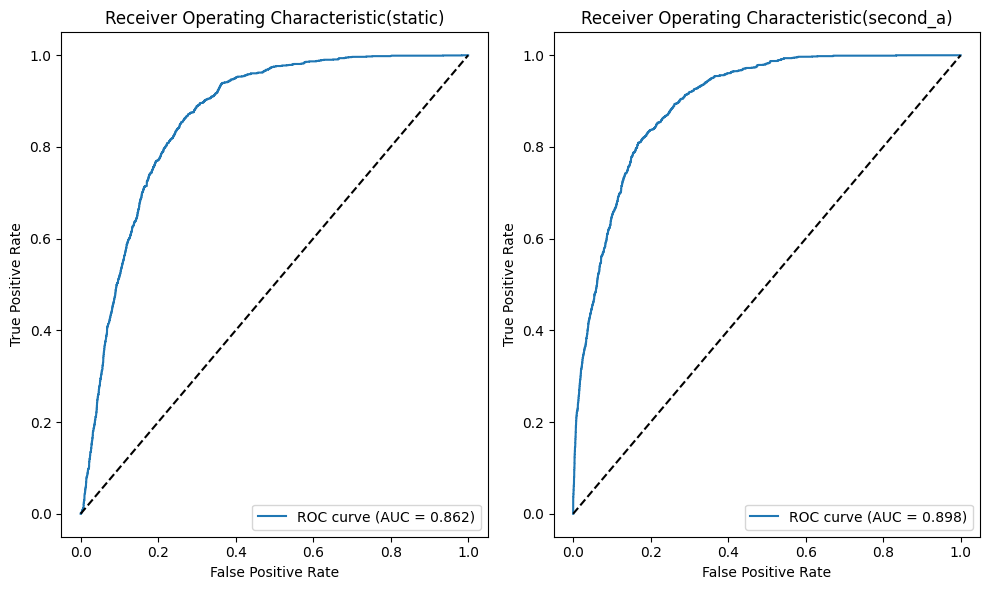

In [680]:
pipeline('features_compiled/radoslaw_email.pickle')